<a href="https://colab.research.google.com/github/NK-Mikey/Data_Analysis/blob/main/Customer%20Segmentation%3A%20RFM%20vs%20KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Customer Segmentation via RFM Analysis and Clustering Using Online Retail Data**

A UK-based online retail company is seeking to enhance its marketing performance by understanding different types of customers and tailoring engagement strategies accordingly. The lack of customer segmentation hinders the company's ability to personalize offers or re-engage inactive clients effectively. The primary objective of this project is to segment customers using their Recency, Frequency, and Monetary values derived from historical transaction data. By applying both RFM scoring and unsupervised clustering techniques, we aim to reveal customer behavior patterns and derive meaningful, business-ready segments that can inform targeted marketing initiatives.

## 1. Import Libraries

In [43]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.patches as mpatches

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator

# Preprocessing
from sklearn.preprocessing import StandardScaler

## 2. Data Loading and Exploring

In [44]:
# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

# Preview the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [45]:
# To understand the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [46]:
# To check the basic descriptive statistics summary of the dataset
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [47]:
# To check the missing values
df.isnull().sum().to_frame('Missing Values').transpose()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Missing Values,0,0,1454,0,0,0,135080,0


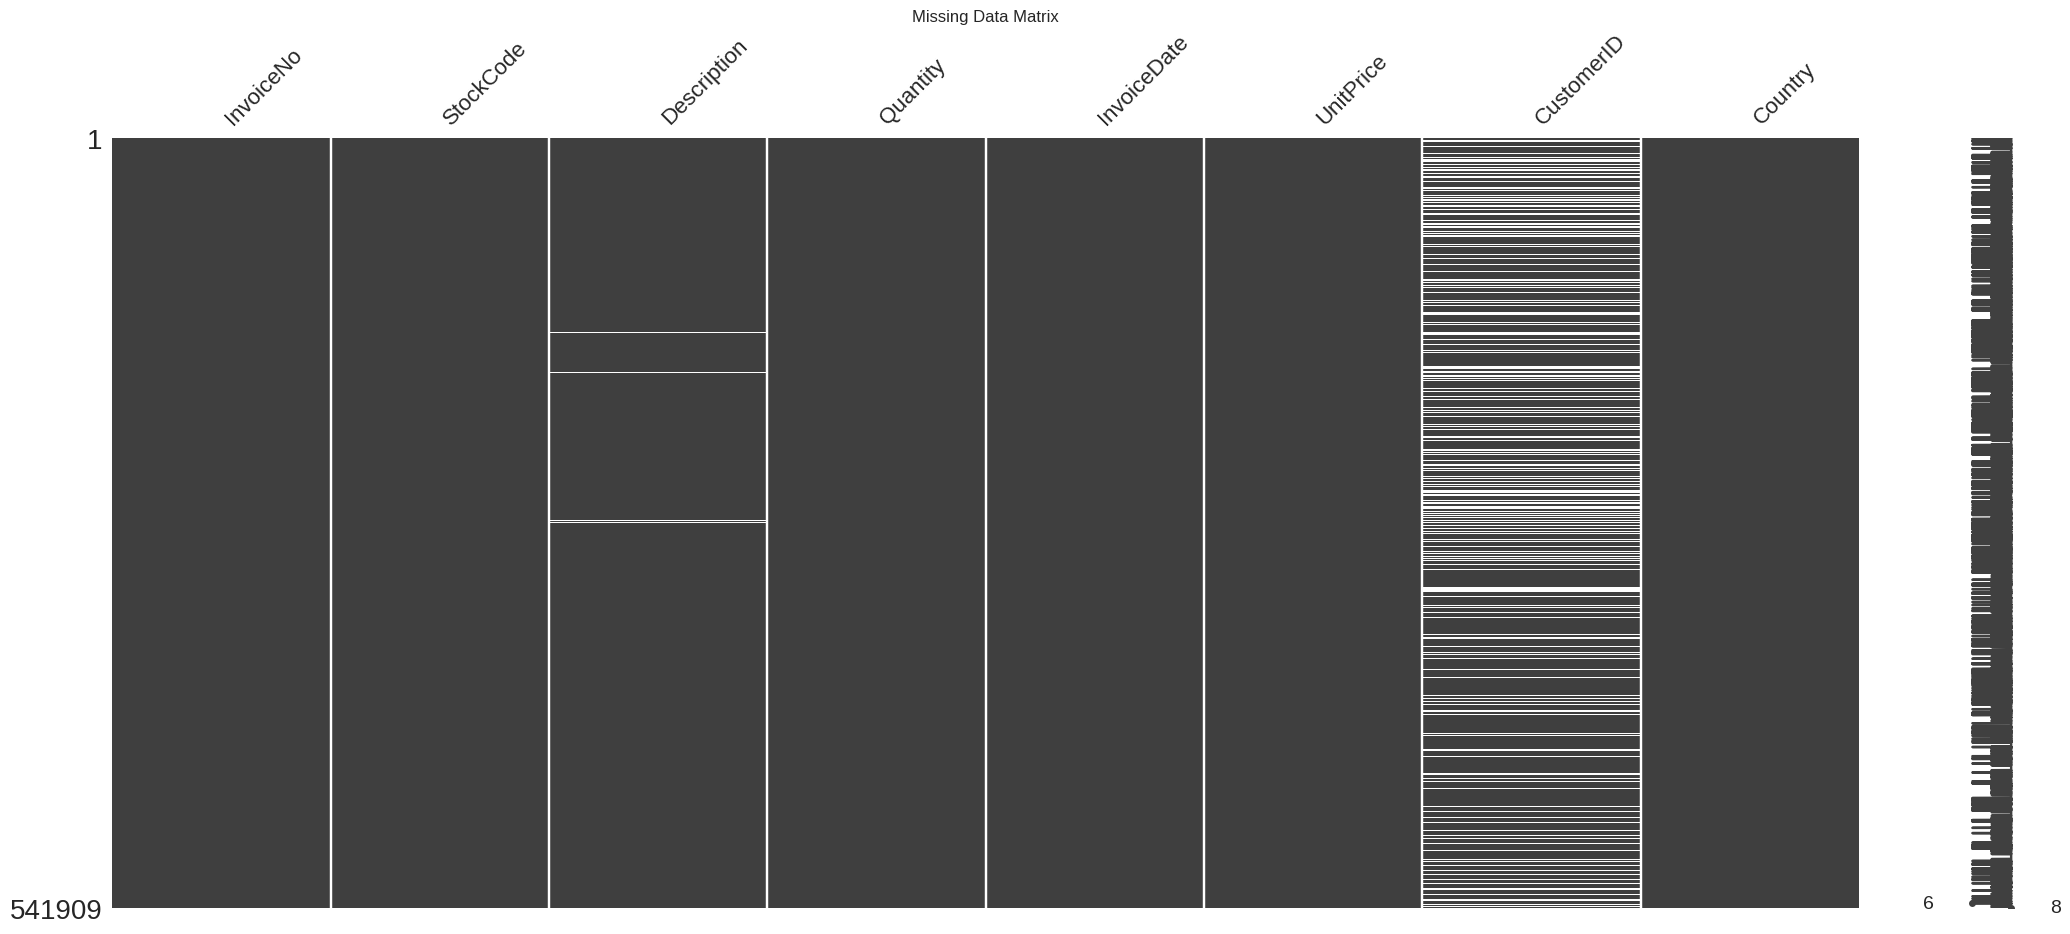

In [48]:
# To visualize the missing values
msno.matrix(df)
plt.title("Missing Data Matrix")
plt.show()

## 3. Data Cleaning

### 3.1 Handling Missing Values

In [49]:
# Drop rows where CustomerID or Description is missing
df = df.dropna(subset=['CustomerID', 'Description'])

# Confirm no of missing values
df.isnull().sum().to_frame('Missing Values').transpose()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Missing Values,0,0,0,0,0,0,0,0


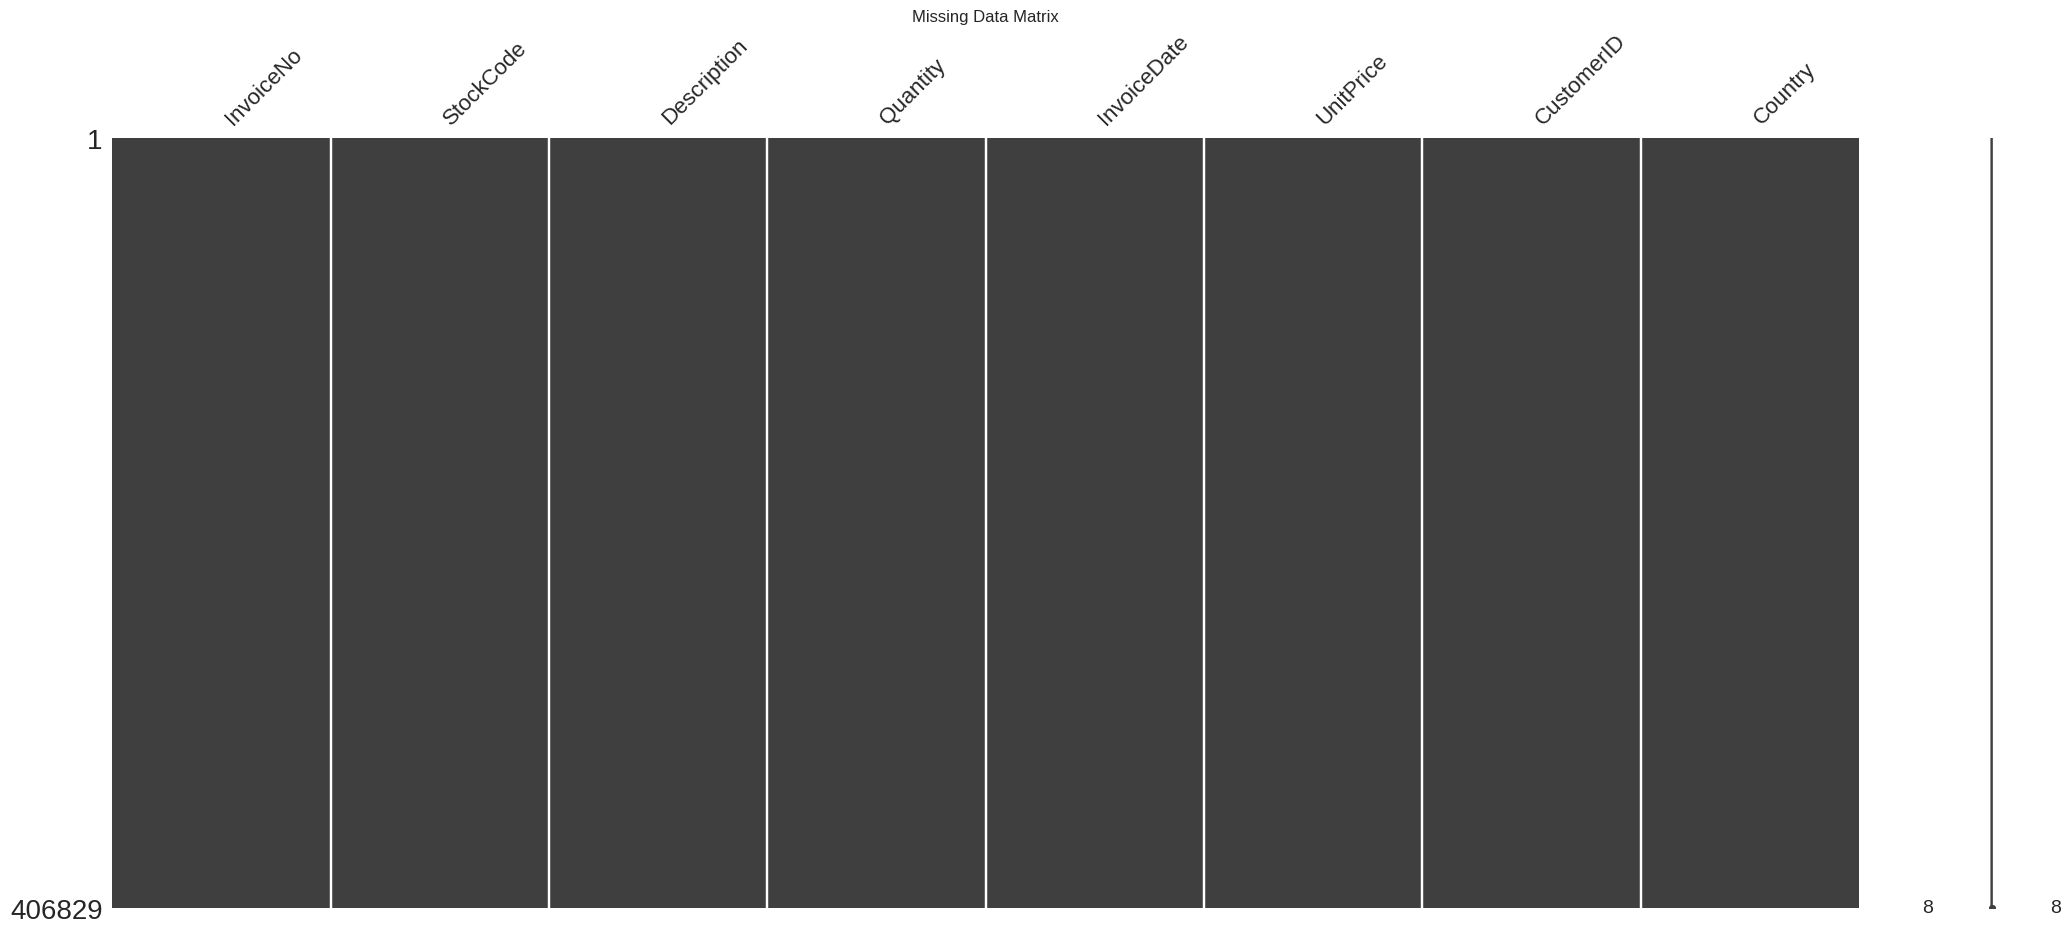

In [50]:
# Confirming no of missing values visually
msno.matrix(df)
plt.title("Missing Data Matrix")
plt.show()

### 3.2 Removal of Return Orders

In [51]:
# Filtering out the customer return orders
df = df[df['Quantity'] > 0]

### 3.3 Computing Total Price Column

In [52]:
# Calculating total price from quantity and unit price
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Preview the changes
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### 3.4  Excluding Zero-Value Transactions

In [53]:
# Filtering out orders with no monetary value
df = df[df['TotalPrice'] > 0]

## 4. RFM Analysis

### 4.1 Computing Recency, Frequency and Monetary

In [54]:
# Set reference date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [55]:
# Group by CustomerID to calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [56]:
# Preview the RFM
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


### 4.2 RFM Scoring

In [57]:
# Assign RFM scores from 1 to 5
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine individual scores into one RFM score string
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

In [58]:
# Preview the RFM Scoring
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [59]:
# Define detailed customer segments
def assign_segment(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    if r == 5 and f == 5 and m == 5:
        return 'Champions'
    elif r == 5 and f >= 4:
        return 'Loyal Customers'
    elif r == 5:
        return 'Recent Customers'
    elif f == 5:
        return 'Frequent Buyers'
    elif m == 5:
        return 'Big Spenders'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'At Risk'
    elif r == 1:
        return 'Lost'
    else:
        return 'Others'

# Apply segmentation
rfm['RFM_Segment'] = rfm.apply(assign_segment, axis=1)

# Summarize segment statistics
segment_summary = (
    rfm.groupby('RFM_Segment')
       .agg({
           'Recency': 'mean',
           'Frequency': 'mean',
           'Monetary': 'mean',
           'CustomerID': 'count'
       })
       .rename(columns={'CustomerID': 'CustomerCount'})
       .round(2)
       .sort_values(by='CustomerCount', ascending=False)
)

segment_summary

,Recency,Frequency,Monetary,CustomerCount
RFM_Segment,,,,
Others,59.48,2.34,713.23,1755
At Risk,228.50,1.04,230.30,824
Frequent Buyers,46.08,9.36,4294.46,429
Champions,5.45,18.24,11221.74,348
Loyal Customers,6.40,5.30,1529.50,285
Lost,248.52,2.07,699.43,281
Recent Customers,6.95,1.92,1375.16,235
Big Spenders,76.19,3.64,4236.60,181


### 4.3 Visualzing RFM by Customer Count

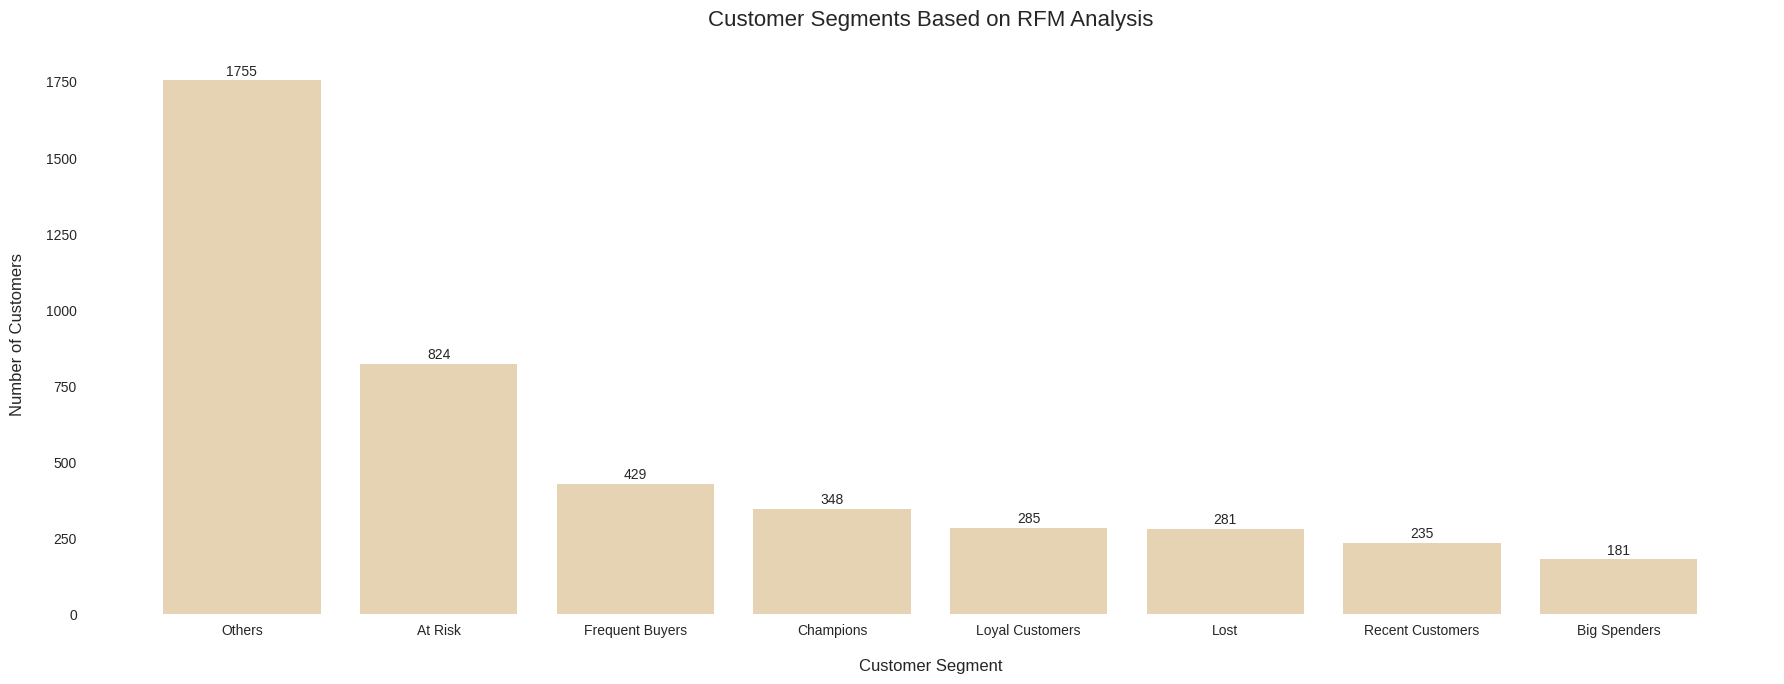

In [60]:
# Sort segments by customer count
segment_summary_sorted = segment_summary.sort_values('CustomerCount', ascending=False)

# Plotting
plt.figure(figsize=(18, 7))
bars = plt.bar(
    segment_summary_sorted.index,
    segment_summary_sorted['CustomerCount'],
    color='#E6D3B3'
)

# Title and labels
plt.title("Customer Segments Based on RFM Analysis", fontsize=16, pad=20)
plt.ylabel("Number of Customers", fontsize=12, labelpad=15)
plt.xlabel("Customer Segment", fontsize=12, labelpad=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove spines (top, right, left, bottom)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, int(height),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.grid(False)
plt.show()

### 4.4 Heatmap of Average RFM by Customer Segment

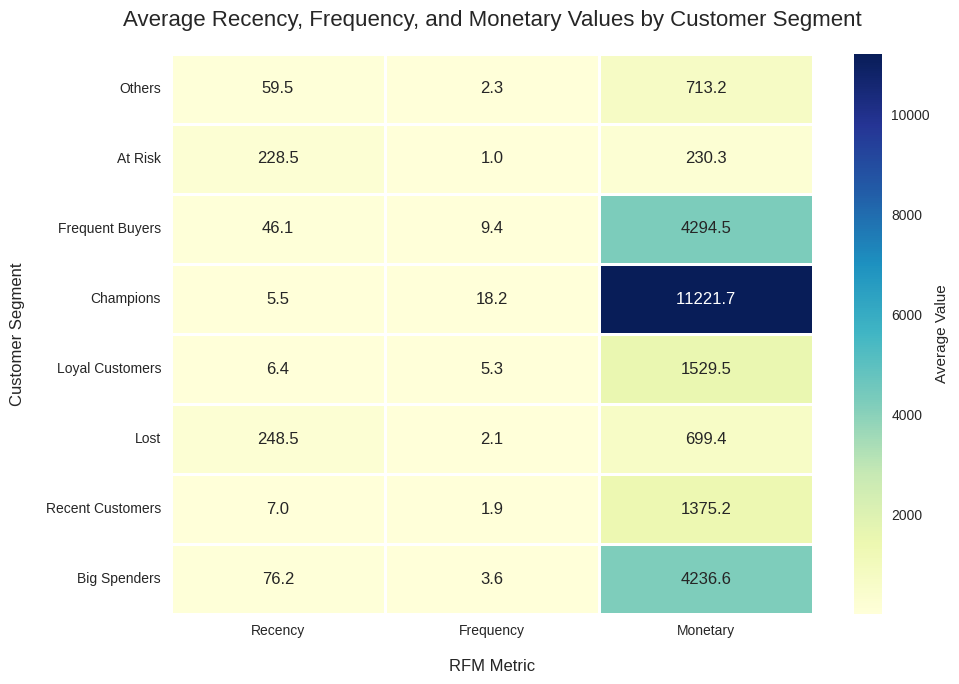

In [61]:
# Prepare data for heatmap: average RFM values by segment
heatmap_data = segment_summary[['Recency', 'Frequency', 'Monetary']]

plt.figure(figsize=(10, 7))

# Create heatmap with annotations and a friendly color palette
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Average Value'},
    linewidths=1,
)

plt.title("Average Recency, Frequency, and Monetary Values by Customer Segment", fontsize=16, pad=20)
plt.ylabel("Customer Segment", fontsize=12, labelpad=15)
plt.xlabel("RFM Metric", fontsize=12, labelpad=15)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

###  **RFM Segment Interpretation**

| Segment            | Recency | Frequency | Monetary | Customer Count | Interpretation |
|--------------------|---------|-----------|----------|----------------|----------------|
| **Champions**       | 5.45    | 18.24     | 11,221.74 | 348            | These are the most valuable customers. They purchase very recently, very frequently, and spend the most. Focus on loyalty rewards, VIP access, and retention. |
| **Loyal Customers** | 6.40    | 5.30      | 1,529.50  | 285            | Reliable repeat buyers who shop recently and often. Moderate spenders. Great candidates for upselling and engagement campaigns. |
| **Frequent Buyers** | 46.08   | 9.36      | 4,294.46  | 429            | Purchase often but not recently. Valuable segment to re-engage with time-limited offers or personalized reminders. |
| **Big Spenders**    | 76.19   | 3.64      | 4,236.60  | 181            | Spend a lot, but don't shop often or recently. High-value targets for luxury or exclusive promotions. May have switched to competitors. |
| **Recent Customers**| 6.95    | 1.92      | 1,375.16  | 235            | New buyers who purchased recently but not yet frequently. Onboarding campaigns can help convert them to loyal customers. |
| **At Risk**         | 228.50  | 1.04      | 230.30    | 824            | Haven’t purchased in a long time, low frequency and spend. May need win-back campaigns, reactivation emails, or surveys. |
| **Lost**            | 248.52  | 2.07      | 699.43    | 281            | Very disengaged customers with some past value. Likely churned. Recovery might be costly; consider targeting only high past spenders. |
| **Others**          | 59.48   | 2.34      | 713.23    | 1,755          | Catch-all segment with moderate recency and low activity. Possibly seasonal or low-interest buyers. Use general promotions to re-engage. |


###  **Key Insights:**

- **Champions** and **Loyal Customers** are the top-performing segments, retain and reward them.
- **Frequent Buyers** and **Big Spenders** have strong potential if re-engaged.
- **Recent Customers** are new, onboard them properly.
- **At Risk** and **Lost** require targeted reactivation or can be de-prioritized.
- **Others** may need deeper segmentation or broader marketing strategies.


## 5. Preprocessing the RFM for Clustering

### 5.1 Feature Selection

In [62]:
# Select only RFM for clustering
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Preview
X.head()

,Recency,Frequency,Monetary
0,326,1,77183.60
1,2,7,4310.00
2,75,4,1797.24
3,19,1,1757.55
4,310,1,334.40


### 5.2 Standardize the RFM dataset

In [63]:
# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(X)

# Convert to DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=X.columns)

# Preview
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.358668
1,-0.905340,0.354417,0.250966
2,-0.175360,-0.035340,-0.028596
3,-0.735345,-0.425097,-0.033012
4,2.174578,-0.425097,-0.191347


### 5.3 Finding Optimal K

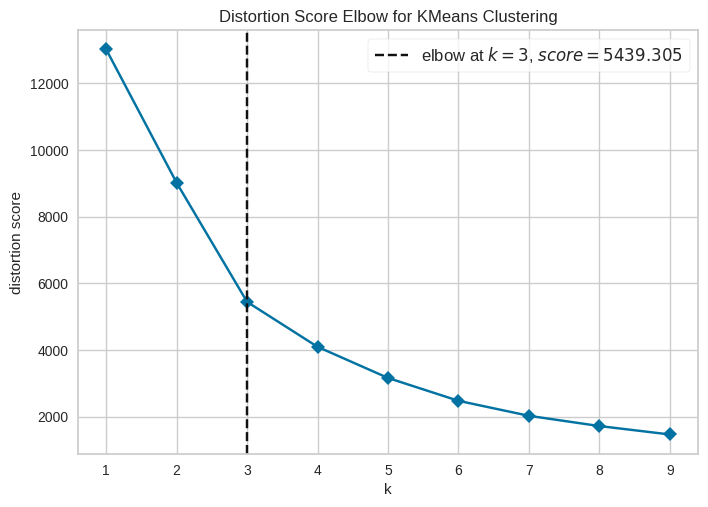



Optimal k found by KneeLocator: 4


In [64]:
# Using the Yellowbrick KElbowVisualizer for a clear visualization
model = KMeans(random_state=18, n_init=10)
visualizer = KElbowVisualizer(model, k=(1,10), metric='distortion', timings=False)

# Fit the data to the visualizer
visualizer.fit(rfm_scaled)
visualizer.show()

# Alternatively, manual calculation
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=18, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

print('\n')

# Run KneeLocator
kneedle = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing', interp_method='polynomial')
print(f"Optimal k found by KneeLocator: {kneedle.elbow}")

In [65]:
# Computing Silhouette score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=18, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"k = {k}, silhouette score = {score:.4f}")

k = 2, silhouette score = 0.8958
k = 3, silhouette score = 0.5942
k = 4, silhouette score = 0.6162
k = 5, silhouette score = 0.5995
k = 6, silhouette score = 0.5983
k = 7, silhouette score = 0.5162
k = 8, silhouette score = 0.4861
k = 9, silhouette score = 0.4770
k = 10, silhouette score = 0.4261


### **Interpretation of Choosing K = 3 Over K = 4**

In the clustering phase of our RFM analysis, we employed several methods to determine the optimal number of customer segments (**K**) to use in K-Means clustering. These included the **Elbow Method**, **Silhouette Analysis**, and **Yellowbrick’s Visualizer**. While these tools yielded slightly differing recommendations, we ultimately chose **K = 3**, and here’s why:



#### **1️ Elbow Method (KneeLocator): Suggested K = 4**

The Elbow Method showed a noticeable "elbow" at **K = 4**, which implies that the marginal gain in explained variance starts to diminish beyond this point. However, this method does **not guarantee optimal cluster separability**, it only tells us when adding more clusters starts to return diminishing gains.



#### **2️ Silhouette Score: Slightly Higher at K = 4**

The average **silhouette score** which measures how well-separated the clusters are was slightly higher for **K = 4** compared to **K = 3**. While silhouette score is a strong indicator of how compact and distinct the clusters are, the improvement from K = 3 to K = 4 was **marginal**, not significant.


#### **3️ Yellowbrick Visualizer: Clear Clarity at K = 3**

The **Yellowbrick KElbowVisualizer** provided a clearer and more stable clustering structure at **K = 3**. The clusters were well-separated and more intuitively aligned with the RFM metrics, showing natural groupings like:

- **Big Spenders**
- **Loyal Customers**
- **Lost Customers**

This structure was easy to interpret and align with business strategy.



#### **4️ Interpretability and Business Relevance**

Choosing **K = 3** allowed for simpler segmentation that still captured the core customer groups:

- One **high-value group**
- One **moderate/loyal group**
- One **disengaged or lost group**

When we tested **K = 4**, the additional cluster seemed to **split an existing group** without adding meaningful business insight, thus complicating the interpretation without tangible benefit.



###  **Conclusion**

Although **K = 4** was suggested by some metrics, the **practical interpretability**, **business relevance**, and **cleaner segment separation** at **K = 3** made it the more suitable choice for this project. It offered a balance between **statistical soundness** and **actionable insights**, the goal of most customer segmentation efforts.


### 5.4 Applying KMeans

In [66]:
# Creating KMeans Model for the optimum no of clustering
kmeans_model = KMeans(n_clusters = 3, random_state = 18)
kmeans_model.fit(rfm_scaled)

# Adding the cluster label to the dataframe
rfm["Cluster"] = kmeans_model.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Segment,Cluster
0,12346.0,326,1,77183.60,1,1,5,115,Big Spenders,2
1,12347.0,2,7,4310.00,5,5,5,555,Champions,1
2,12348.0,75,4,1797.24,2,4,4,244,Others,1
3,12349.0,19,1,1757.55,4,1,4,414,Others,1
4,12350.0,310,1,334.40,1,1,2,112,At Risk,2


In [67]:
# View cluster counts
rfm['Cluster'].value_counts()

,count
Cluster,
1,3230
2,1082
0,26


### 5.5 Visualization of the Clusters

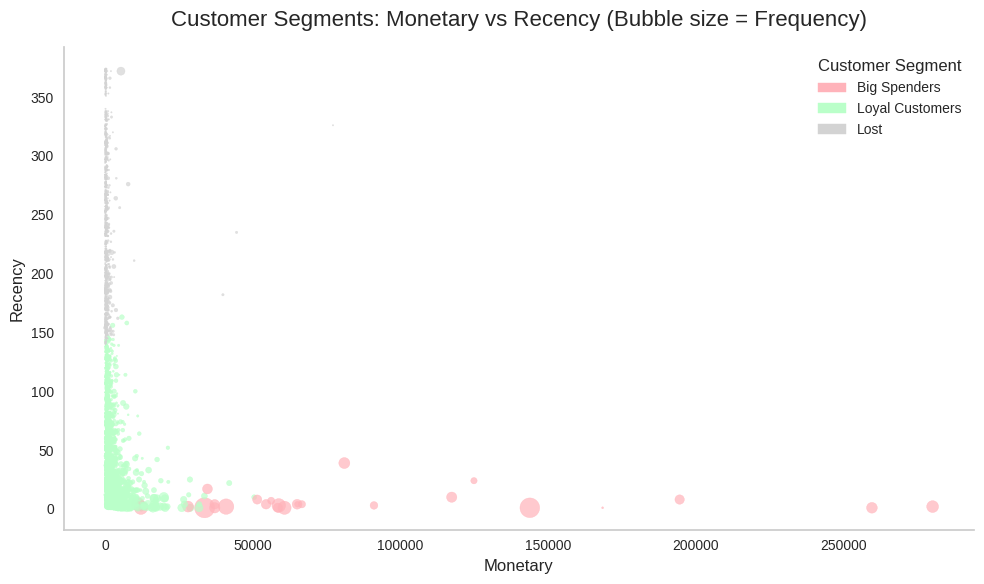

In [68]:
# Define cluster segments
cluster_name_map = {
    0: "Big Spenders",
    1: "Loyal Customers",
    2: "Lost",
}

rfm['Cluster_Segment'] = rfm['Cluster'].map(cluster_name_map)

# Define cluster color mapping
colors_map = {
    0: '#FFB3BA',  # light pink
    1: '#BAFFC9',  # light green
    2: '#D3D3D3',  # light grey
}

# Map colors
colors = rfm["Cluster"].map(colors_map)

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    rfm["Monetary"],
    rfm["Recency"],
    s=rfm["Frequency"],
    c=colors,
    alpha=0.7
)

# Create custom legend with descriptive names
legend_handles = [
    mpatches.Patch(color=colors_map[cluster], label=cluster_name_map[cluster])
    for cluster in colors_map
]

plt.legend(handles=legend_handles, title='Customer Segment')
plt.xlabel('Monetary', fontsize=12)
plt.ylabel('Recency', fontsize=12)
plt.title('Customer Segments: Monetary vs Recency (Bubble size = Frequency)', fontsize=16, pad=15)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.grid(False)
plt.tight_layout()
plt.show()

###  **Customer Segments: Monetary vs Recency (Bubble Size = Frequency)**

In the visualization of customer segments based on Monetary vs. Recency with bubble size representing Frequency, distinct patterns emerge among different customer groups.

- **Big Spenders (Pink)** are characterized by low recency (typically between 0–50 days), very high monetary values (up to 250,000+), and often large bubble sizes, indicating high purchase frequency. These individuals are recent, frequent, and high-value customers, making them a critical segment for retention and exclusive targeting.

- **Loyal Customers (Green)** also display low recency but have moderate monetary values. Their bubbles are medium to large in size, reflecting steady purchase activity. These customers are active and reliable, though their spending does not match that of Big Spenders. However, they represent a dependable group that responds well to continued engagement and rewards.

- **Lost Customers (Gray)** have high recency values (100+ days), low monetary value, and small bubble sizes. This indicates they are largely inactive and contribute minimally in terms of purchases and revenue. They represent a segment that either needs targeted reactivation efforts or may be deprioritized based on business goals.

From an overall perspective, there is a clear inverse relationship between recency and monetary value, as recency decreases (i.e., customers are more recent), monetary value tends to increase. The most valuable customers tend to cluster in the bottom-left of the plot (recent and high spend), while lost customers dominate the top-left (long inactive and low spend).

Based on these insights, tailored business strategies can be adopted. Big Spenders should be rewarded with VIP offers and personalized promotions to retain their loyalty. Loyal Customers can be further nurtured through rewards and tailored product recommendations. Lost Customers may be targeted with reactivation campaigns, or depending on ROI analysis, potentially excluded from active marketing efforts.


### 5.6 Heatmap of Average RFM per Cluster

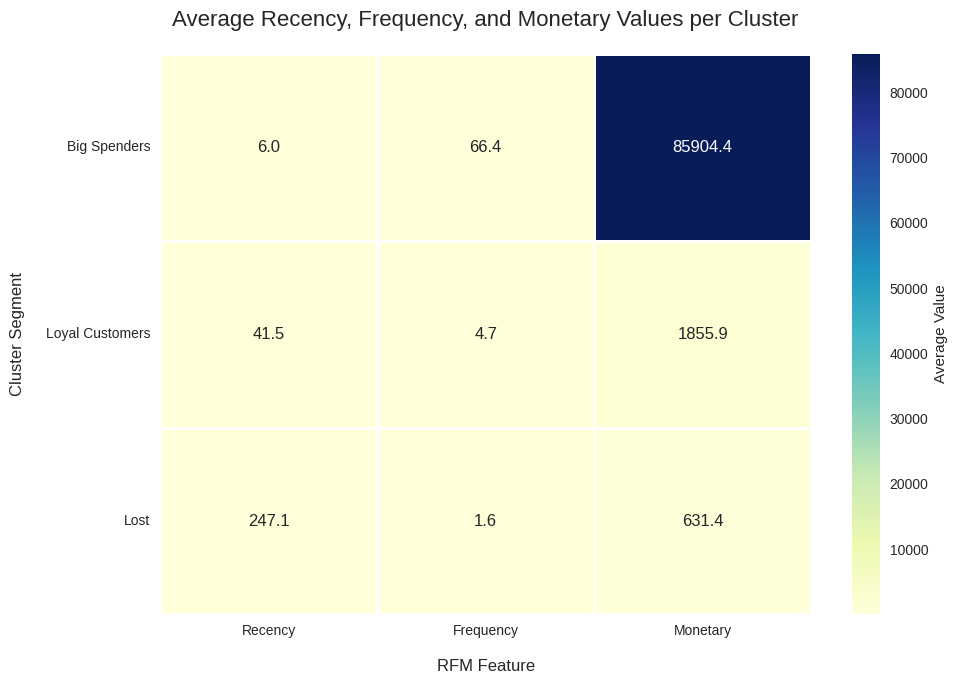

In [69]:
# Map cluster numbers to names
cluster_name_map = {
    0: "Big Spenders",
    1: "Loyal Customers",
    2: "Lost",
}

# Aggregate average RFM values per cluster
cluster_avg = (
    rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']]
    .mean()
    .round(1)
    .sort_index()
)

# Rename index
cluster_avg.index = cluster_avg.index.map(cluster_name_map)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    cluster_avg,
    annot=True,
    fmt=".1f",
    cmap='YlGnBu',
    linewidths=1,
    cbar_kws={'label': 'Average Value'}
)

# Title and axis formatting
plt.title('Average Recency, Frequency, and Monetary Values per Cluster', fontsize=16, pad=20)
plt.xlabel('RFM Feature', fontsize=12, labelpad=15)
plt.ylabel('Cluster Segment', fontsize=12, labelpad=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

### 5.7 Heatmap of Comparison Between RFM segments vs KMeans Clusters

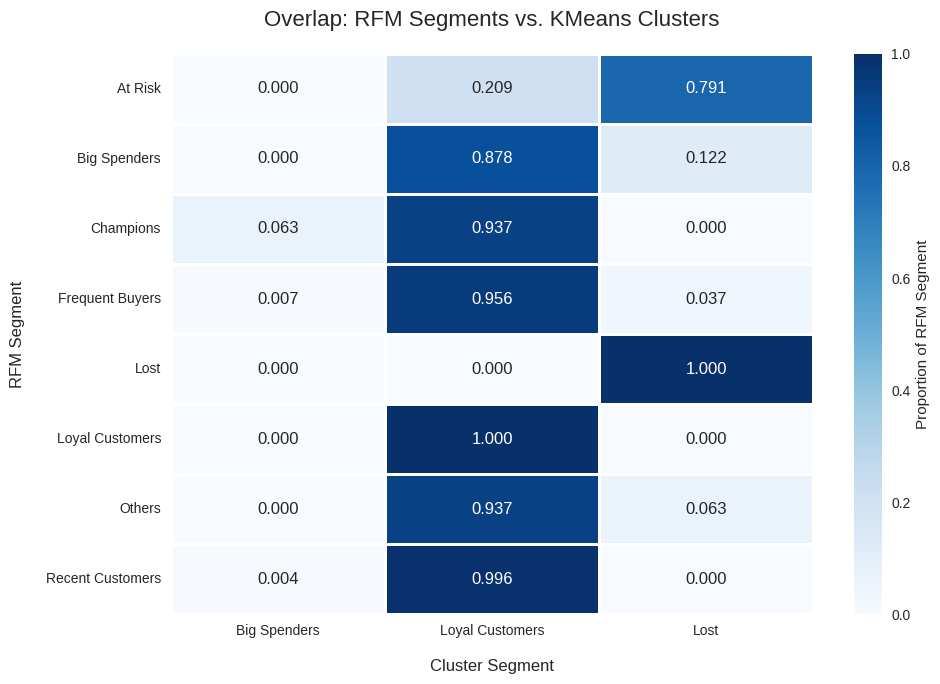

In [70]:
# Creating the raw crosstab (proportions by RFM segment)
ct = pd.crosstab(
    rfm['RFM_Segment'],
    rfm['Cluster_Segment'],
    normalize='index'
)

# Order of apprearence
desired_cols = ["Big Spenders", "Loyal Customers", "Lost"]
ct = ct.reindex(columns=desired_cols).fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    ct,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    linewidths=1,
    cbar_kws={'label': 'Proportion of RFM Segment'}
)

plt.title("Overlap: RFM Segments vs. KMeans Clusters", fontsize=16, pad=20)
plt.ylabel("RFM Segment", fontsize=12, labelpad=15)
plt.xlabel("Cluster Segment", fontsize=12, labelpad=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

### **Interpretation of Cluster vs RFM Segment Comparison**

This table shows how different RFM-based customer segments align with broader cluster groups labeled as **Big Spenders**, **Loyal Customers**, and **Lost**.

| RFM Segment        | Big Spenders | Loyal Customers | Lost    |
|--------------------|--------------|-----------------|---------|
| **At Risk**        | 0.00         | 20.87%          | 79.13%  |
| **Big Spenders**   | 0.00         | 87.85%          | 12.15%  |
| **Champions**      | 6.32%        | 93.68%          | 0.00    |
| **Frequent Buyers**| 0.70%        | 95.57%          | 3.73%   |
| **Lost**           | 0.00         | 0.00            | 100%    |
| **Loyal Customers**| 0.00         | 100%            | 0.00    |
| **Others**         | 0.00         | 93.68%          | 6.32%   |
| **Recent Customers**| 0.43%       | 99.57%          | 0.00    |


### **Key Insights**

- Most **"At Risk"** customers fall into the **"Lost"** cluster, indicating they are likely inactive or churned. A smaller portion maps to **"Loyal Customers"**.
- The majority of **"Big Spenders"** are classified as **"Loyal Customers"**, highlighting that high spending customers tend to be loyal.
- Nearly all **"Champions"**, **"Frequent Buyers"**, **"Recent Customers"**, and **"Others"** are part of the **"Loyal Customers"** cluster, showing they are active and valuable.
- The **"Lost"** cluster perfectly aligns with the **"Lost"** RFM segment, indicating a consistent identification of inactive customers.
- Overall, the **"Loyal Customers"** cluster covers a large and diverse group, including recent, frequent, and big-spending buyers.
- This segmentation confirms a good alignment between RFM analysis and clustering, validating the segmentation strategy.



### **Business Implications**

- Focus retention and loyalty programs on the **"Loyal Customers"** to maximize lifetime value.
- Develop **win-back campaigns** targeting the **"Lost"** and **"At Risk"** clusters to reduce churn.
- Recognize **"Big Spenders"** as a valuable subset within loyal customers and offer them exclusive rewards.
- Use this segmentation to tailor marketing strategies effectively, improving customer engagement and ROI.
